In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(image_size=(128, 128)):
  (ds_train, ds_validation), ds_info = tfds.load(
      'oxford_flowers102',
      split=['train', 'validation'],
      shuffle_files=True,
      as_supervised=True,
      with_info=True,
  )

  num_classes = ds_info.features['label'].num_classes

  def preprocess(image, label):
    image = tf.image.resize(image, image_size)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

  ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(64).prefetch(tf.data.AUTOTUNE)
  ds_validation = ds_validation.map(preprocess).cache().batch(64).prefetch(tf.data.AUTOTUNE)

  return ds_train, ds_validation, num_classes, ds_info

In [ ]:
IMG_SIZE = (224, 224)
train_dataset, validation_dataset, num_classes, ds_info = load_dataset(IMG_SIZE)

class_names=ds_info.features['label'].names

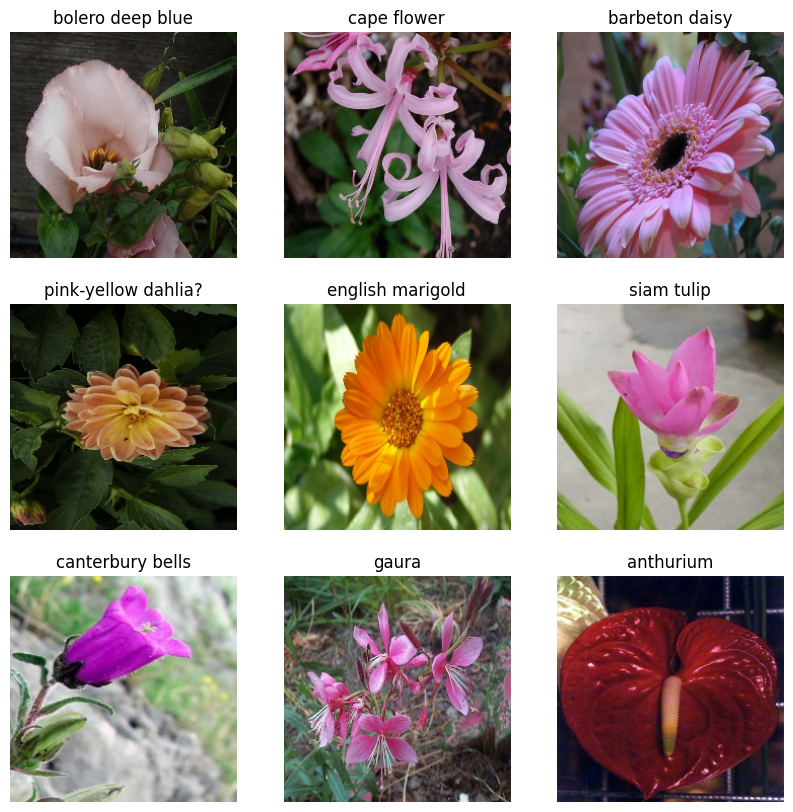

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip("horizontal"))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

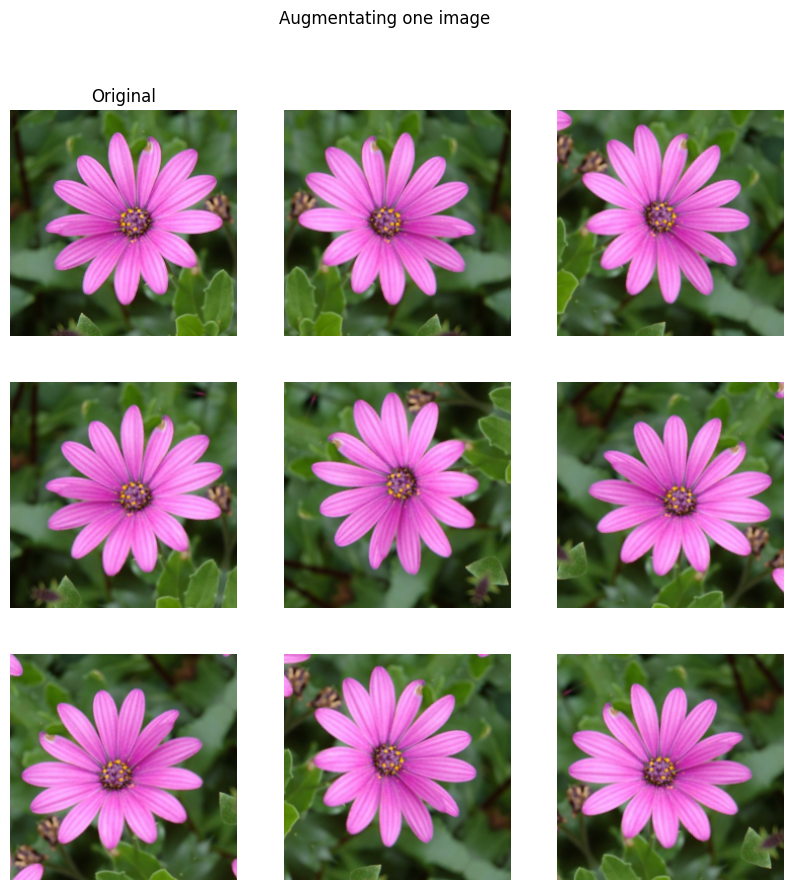

In [ ]:
data_augmentation = data_augmenter()

for images, labels in train_dataset.take(1):
    first_image = images[0]

    plt.figure(figsize=(10, 10))
    plt.suptitle("Augmentating one image")

    ax = plt.subplot(3, 3, 1)
    plt.imshow(first_image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis('off')

    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')

plt.show()


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
train_dataset_vgg = train_dataset.map(lambda image, label: (preprocess_input(image), label))

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
def flower_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
  input_shape = image_shape + (3,)

  base_model = VGG16(input_shape=input_shape,
                       include_top=False,
                       weights='imagenet',
                     name='vgg16')

  base_model.trainable = False

  inputs = Input(shape=input_shape)

  x = data_augmentation(inputs)

  x = preprocess_input(x)

  x = base_model(x, training=False)

  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.2)(x)

  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs, outputs)

  return model


In [ ]:
model = flower_model(IMG_SIZE, data_augmenter())

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 590ms/step - accuracy: 0.0299 - loss: 12.6544 - val_accuracy: 0.0343 - val_loss: 9.0032
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 581ms/step - accuracy: 0.0326 - loss: 9.3284 - val_accuracy: 0.0686 - val_loss: 7.0399
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 609ms/step - accuracy: 0.0563 - loss: 7.1956 - val_accuracy: 0.1510 - val_loss: 5.4553
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 560ms/step - accuracy: 0.1030 - loss: 5.8645 - val_accuracy: 0.2176 - val_loss: 4.3371
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step - accuracy: 0.1973 - loss: 4.6179 - val_accuracy: 0.3029 - val_loss: 3.5634
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 547ms/step - accuracy: 0.2531 - loss: 3.7799 - val_accuracy: 0.3814 - val_loss: 2.9645
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.3372 - loss: 3.1005 - val_accuracy: 0.4392 - val_loss: 2.5755
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - accuracy: 0.4368 - loss: 2.5708 - val_accuracy: 

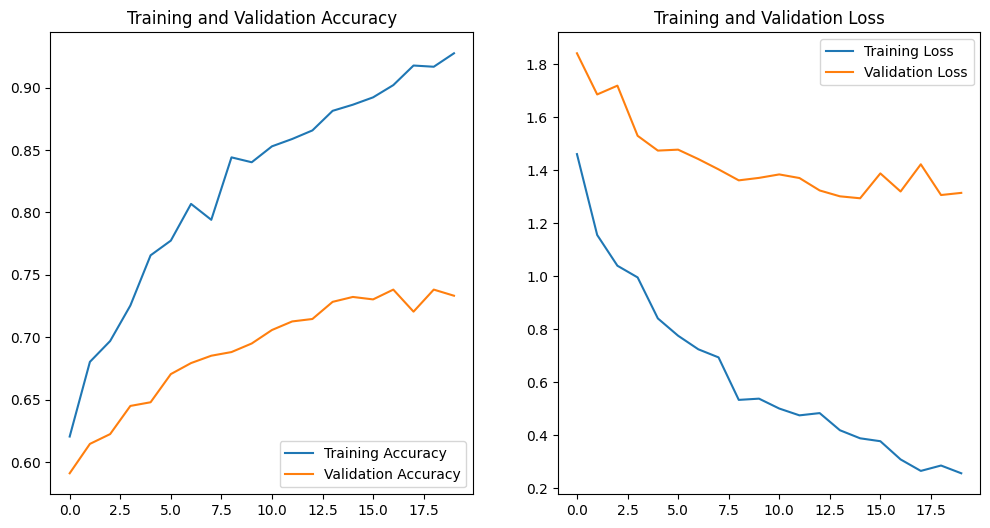

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.7433 - loss: 1.2307
Validation Loss: 1.3153
Validation Accuracy: 73.33%


In [ ]:
base_model = model.get_layer('vgg16')
base_model.trainable = True

# VGG has 19 layers
fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

initial_epochs = 10
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(train_dataset,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=validation_dataset)


Epoch 20/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 705ms/step - accuracy: 0.9891 - loss: 0.0366 - val_accuracy: 0.8098 - val_loss: 1.1595
Epoch 21/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 706ms/step - accuracy: 0.9814 - loss: 0.0502 - val_accuracy: 0.7990 - val_loss: 1.2038
Epoch 22/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 722ms/step - accuracy: 0.9844 - loss: 0.0483 - val_accuracy: 0.8147 - val_loss: 1.2343
Epoch 23/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - accuracy: 0.9889 - loss: 0.0504 - val_accuracy: 0.8039 - val_loss: 1.2387
Epoch 24/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step - accuracy: 0.9895 - loss: 0.0413 - val_accuracy: 0.8147 - val_loss: 1.1646
Epoch 25/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 687ms/step - accuracy: 0.9877 - loss: 0.0327 - val_accuracy: 0.8010 - val_loss: 1.2242
Epoch 26/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - accuracy: 0.9878 - loss: 0.0390 - val_accuracy: 0.8049 - val_loss: 1.1922
Epoch 27/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 684ms/step - accuracy: 0.9894 - loss: 0.0272 - 

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.8093 - loss: 1.0867
Validation Loss: 1.1755
Validation Accuracy: 80.39%
